In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import scipy

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=7,
                    suppress=True)

# First data analysis

In [262]:
df = pd.read_csv('BostonHousing.csv')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


Analize missing values.

In [263]:
missed = dict()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    
    if pct_missing > 0:
        print('{} - {}%'.format(col, round(pct_missing*100)))
        missed[col] = pct_missing * 100

In [264]:
len(missed)

0

In [265]:
tgt = df.pop('medv')
y = tgt

In [266]:
del df['chas']

# Dummy linear

In [267]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import make_scorer

scorer = make_scorer(mape)
model = LinearRegression()
score = cross_val_score(model, df, y=y,
                        scoring=scorer, cv=10)
score.mean()

0.2122367689080583

In [268]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge

def dummy_linear_score(df, y, cv=5):
    scorer = make_scorer(mape)
    model = LinearRegression()
    cv = KFold(cv, shuffle=True)
    return cross_val_score(model, df, y,
                          scoring=scorer, cv=cv)

def dummy_lasso_score(df, y, cv=5):
    scorer = make_scorer(mape)
    model = Lasso()
    cv = KFold(cv, shuffle=True)
    return cross_val_score(model, df, y,
                          scoring=scorer, cv=cv)

def dummy_ridge_score(df, y, cv=5):
    scorer = make_scorer(mape)
    model = Ridge()
    cv = KFold(cv, shuffle=True)
    return cross_val_score(model, df, y,
                          scoring=scorer, cv=cv)

# Polynomial features

In [269]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
df_poly = poly.fit_transform(df)
df = df_poly


In [270]:
df = pd.DataFrame(df)

# Target transforming

In [271]:
y_log = np.log(y.values)

def bias(model, df_train, y_train):
    y_pred = model(df_train)
    bias = sum((y_pred - y_train) ** 2) / (2 * len(y_train))
    return bias

y = y_log

# Feature selection

F-test for feature influences

In [272]:
from sklearn.feature_selection import f_regression

p_values = f_regression(df, y)[1]
threshold = 0.02
idx = np.arange(df.values.shape[1])
filt = p_values < threshold

f_cols = df.columns[idx[filt]]
df[f_cols]

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,...,74529.0,5733.0,107013.27,2639.91,441.00,8231.790,203.070,153656.1601,3790.5433,93.5089
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,...,74529.0,5733.0,108353.70,2478.84,441.00,8334.900,190.680,157529.6100,3603.8520,82.4464
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,...,74529.0,5733.0,108353.70,1539.72,441.00,8334.900,118.440,157529.6100,2238.5160,31.8096
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,...,74529.0,5733.0,107411.85,1769.04,441.00,8262.450,136.080,154802.9025,2549.5560,41.9904


Prune high-correlated features

In [273]:
corr_matrix = df[f_cols].corr().abs()

corr_pairs = []
for i in range(len(f_cols)):
    for j in range(i):
        if corr_matrix.values[i][j] > 0.995:
            corr_pairs.append([f_cols[i], f_cols[j]])
    
to_drop = set()
for pair in corr_pairs:
    to_drop.add(max(*pair))
    
df = df[f_cols].drop(columns=to_drop)

In [274]:
df

,1,2,3,4,5,6,7,8,9,10,...,80,81,82,83,84,86,87,88,89,90
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,...,4.98,87616.0,4528.8,117482.40,1474.08,6072.570,76.194,157529.6100,1976.5620,24.8004
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,...,18.28,58564.0,4307.6,96049.80,2211.88,7064.820,162.692,157529.6100,3627.6660,83.5396
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,...,8.06,58564.0,4307.6,95064.86,975.26,6992.374,71.734,154315.4089,1583.1049,16.2409
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,...,8.82,49284.0,4151.4,87607.86,652.68,7379.581,54.978,155732.8369,1160.2122,8.6436
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,...,15.99,49284.0,4151.4,88111.80,1183.26,7422.030,99.671,157529.6100,2115.4770,28.4089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,...,9.67,74529.0,5733.0,107013.27,2639.91,8231.790,203.070,153656.1601,3790.5433,93.5089
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,...,9.08,74529.0,5733.0,108353.70,2478.84,8334.900,190.680,157529.6100,3603.8520,82.4464
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,...,5.64,74529.0,5733.0,108353.70,1539.72,8334.900,118.440,157529.6100,2238.5160,31.8096
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,...,6.48,74529.0,5733.0,107411.85,1769.04,8262.450,136.080,154802.9025,2549.5560,41.9904


# Stepwise selection

In [275]:
from mlxtend.feature_selection import SequentialFeatureSelector

model = LinearRegression()
cv = KFold(shuffle=True)

sfs = SequentialFeatureSelector(model, k_features=15, forward=True,
                                floating=True, 
                                scoring='neg_mean_absolute_percentage_error', cv=cv,
                                verbose=True, n_jobs=-1)
sfs.fit(df, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    0.2s finished
Features: 1/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                          estimator=LinearRegression(), floating=True,
                          k_features=15, n_jobs=-1,
                          scoring='neg_mean_absolute_percentage_error',
                          verbose=True)

In [276]:
sfs_cols = list(sfs.k_feature_names_)

In [277]:
sfs.k_feature_idx_

(4, 8, 10, 11, 14, 39, 42, 44, 48, 49, 50, 55, 62, 68, 70)

In [292]:
scores = []
for i in range(60):
    scores.append(dummy_linear_score(df[sfs_cols], y).mean())
    # scores.append(dummy_linear_score(df, y).mean())

sum(scores) / len(scores)

0.040890735994165976

In [279]:
df = df[sfs_cols]

# Outliers

In [280]:
X = df.values

pseudo_inv = np.linalg.inv(X.T @ X)
leverage = (X @ pseudo_inv) @ X.T
leverage

array([[0.0106553, 0.0082125, 0.008269 , ..., 0.0080336, 0.0076366,
        0.0078263],
       [0.0082125, 0.0115263, 0.0078672, ..., 0.006495 , 0.006696 ,
        0.0062815],
       [0.008269 , 0.0078672, 0.012374 , ..., 0.0120598, 0.0109818,
        0.0074596],
       ...,
       [0.0080336, 0.006495 , 0.0120598, ..., 0.0241673, 0.0226255,
        0.0190064],
       [0.0076366, 0.006696 , 0.0109818, ..., 0.0226255, 0.0214577,
        0.0187979],
       [0.0078263, 0.0062815, 0.0074596, ..., 0.0190064, 0.0187979,
        0.0212955]])

In [281]:
p = df.shape[1]
outliers = []
n = df.shape[0]

for i in range(df.shape[0]):
    if leverage[i][i] > (2 * p) / n:
        outliers.append(i)
        
len(outliers)

51

In [282]:
df_tmp = df.drop(outliers)
y_tmp = np.delete(y, outliers, axis=0)

dummy_lasso_score(df_tmp, y_tmp).mean()

0.04526955623126986

# Distribution analysis

<AxesSubplot:ylabel='Density'>

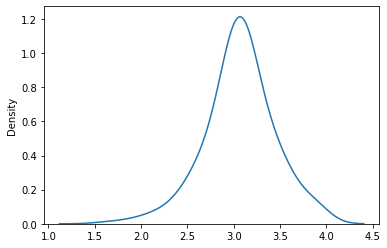

In [283]:
import seaborn as sns

sns.kdeplot(y_tmp, bw_adjust=1.5)

# Residual analysis

0.03319957973999681

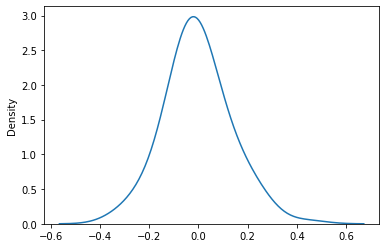

In [288]:
from sklearn.model_selection import train_test_split as split

df_train, df_val, y_train, y_val = split(df_tmp, y_tmp,
                                         shuffle=True,
                                         test_size=0.25)
model = LinearRegression()
model.fit(df_train, y_train)

y_pred = model.predict(df_val)

res = (y_val - y_pred)

sns.kdeplot(res,
           bw_adjust=1.5)
mape(y_val, y_pred)

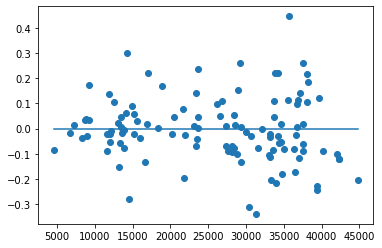

In [289]:
# norms = (df_val.values ** 2).sum(axis=-1) ** (1 / 2)
norms = (df_val ** 2).values.sum(axis=-1) ** (1 / 2)
plt.scatter(norms, res)
plt.plot([norms.min(), norms.max()], [0, 0])

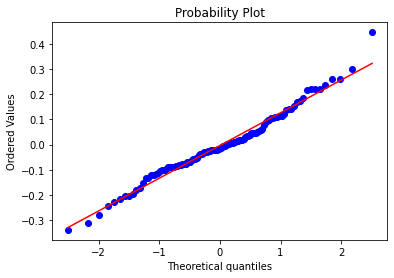

In [290]:
import numpy as np 
import scipy.stats as stats

stats.probplot(res, dist="norm", plot=plt)
plt.show()

In [291]:
bias = sum((y_train - model.predict(df_train)) ** 2) / (2 * len(y_train))
mape(np.exp(y_val), np.exp(y_pred + bias))

0.09967159881836972